### Executive Summary
Dear CEO,
Thank you for the oppurtunity to work with you on this special project to better understand the movie industry. We have conducted a series of analysis to better understand top selling movies, fast growing georaphies and who to partner with in order for Microsoft to enter into the movie industry.

 We have found the following insights:
     1. The most successfull movie genres by revenue, ROI and ratings contain a "Horror" element, so Microsoft should target that segement for first their first movie
     2. Higher IMDB ratings seem to not necessarily lead to higher movie revenues
     3. High grossing movies seem to have a higher ROI, Microsoft should not neccesarly get fixated on creating high ratings movie but should rather focus on creating a high grossing movie
     4. We recomend Microsoft patner with Directors with high ROI. We were able to identify only one director with a high ROI and also a high IMDB ratings.
     5. Average runtime of successful movies have been between 80 mins and 130 mins. Target runtime for new movie should be within this range
     6. DR and LD are some of the best studios and should be targeted for a partnership 
     
 This analysis is based on the following questions:
    1. What are the most successful genres by revenue?
    2. What are the most successful genres by ROI?
    3. What are the most popular movie genres?
    4. Do higher IMDB ratings lead to higher movie revenues?
    5. Have high grossing movies automatically a higher ROI?
    6. Who are the best directors to partner with in winning genres?
    7. What are the common runtimes by genre?
    8. Which studio should Microsoft partner with?

### Importing Python libraries

The sets of codes below have been carefully written to import a number of python libraries needed to import, interprete and manipulate data in order to generate inisights needed.

In [2]:
#importing matplot
import matplotlib.pyplot as plt 

# Set plot space as inline for inline plots display
%matplotlib inline

#importing numpy
import numpy as np 

# importing pandas into jupyter notebook
import pandas as pd

### Importing data from SQL

Running the below codes creates a connection between python and the SQL database and enables python to pull data from the "Movies" database. 
Three tables (*Box Office Mojo*; *IMDB*; *Rotten Tomatoes*) were merged in SQL into a larger database and the inported into pandaas dataframe. This enabled the team generate depper insights across databases.

In [3]:
#importing SQL connector
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

#importing merged database (*Box Office Mojo*; *IMDB*; *Rotten Tomatoes*)
df = pd.read_sql_query("""
                         SELECT  title, studio, bom_movie_gross.domestic_gross, 
                                 foreign_gross, year, tconst, runtime_minutes, genres, 
                                 averagerating, numvotes, directors, writers, production_budget
                         FROM movies.bom_movie_gross
                         JOIN imdb_title_basics
                         ON title = primary_title
                         JOIN imdb_title_ratings
                         USING (tconst)
                         JOIN imdb_title_crew
                         USING (tconst)
                         JOIN tn_movie_budgets
                         ON title = movie;
                         """, con)
# getting first 5 rows of imported data
df.head()

,title,studio,domestic_gross,foreign_gross,year,tconst,runtime_minutes,genres,averagerating,numvotes,directors,writers,production_budget
0,Toy Story 3,BV,415000000.0,652000000.0,2010,tt0435761,103.0,"Adventure,Animation,Comedy",8.3,682218,nm0881279,"nm0005124,nm0004056,nm0881279,nm1578335","$200,000,000"
1,Inception,WB,292600000.0,535700000.0,2010,tt1375666,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,nm0634240,nm0634240,"$160,000,000"
2,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,tt0892791,93.0,"Adventure,Animation,Comedy",6.3,167532,nm0593610,"nm0825308,nm0458441,nm0501359,nm0011470,nm0254...","$165,000,000"
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000.0,2010,tt1325004,124.0,"Adventure,Drama,Fantasy",5.0,211733,nm1720541,"nm0742279,nm2769412","$68,000,000"
4,Iron Man 2,Par.,312400000.0,311500000.0,2010,tt1228705,124.0,"Action,Adventure,Sci-Fi",7.0,657690,nm0269463,"nm0857620,nm0498278,nm1411347,nm1293367,nm0456158","$170,000,000"


### Cleaning the dataset

The following methodology was leveraged in order to clean the dataset into a workable version:
* Tranformed old 'Directors' column from (one column containing multiple values) to multiple columns contianing one value)
* Created new total_gross column (domestic_gross + foreign_gross)
* Created new ROI column  (total_gross / production_budget -1)
* Removed rows containing empty/ no values for total_gross
* Converted columns (production_budget; total_gross; domestic_gross; foreign_gross) into integers

In [4]:
# creating new database with split value columns
directors = df["directors"].str.split(",", n = 1, expand = True)
# making separate director columns from new data frame 
df["director1"]= directors[0] 
df["director2"]= directors[1]
# Dropping old directors columns 
df.drop(columns =["directors"], inplace = True)

# creating total gross column
df["total_gross"]= df['domestic_gross'] + df['foreign_gross']

# removing empty cells
df['total_gross'].replace('', np.nan, inplace=True)
df.dropna(subset=['total_gross'], inplace=True)

# cleaning production budget into integers
df['production_budget'] = df['production_budget'].str.replace(',', '')
df['production_budget'] = df['production_budget'].str.replace('$', '')
df['production_budget'] = df['production_budget'].astype(int)

# creating ROI column
df["ROI"]= (df['total_gross'] / df['production_budget']) -1 

# converting columns to integer
df['total_gross'] = df['total_gross'].astype(int)
df['domestic_gross'] = df['domestic_gross'].astype(int)
df['foreign_gross'] = df['foreign_gross'].astype(int)
df.head()

,title,studio,domestic_gross,foreign_gross,year,tconst,runtime_minutes,genres,averagerating,numvotes,writers,production_budget,director1,director2,total_gross,ROI
0,Toy Story 3,BV,415000000,652000000,2010,tt0435761,103.0,"Adventure,Animation,Comedy",8.3,682218,"nm0005124,nm0004056,nm0881279,nm1578335",200000000,nm0881279,None,1067000000,4.335000
1,Inception,WB,292600000,535700000,2010,tt1375666,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,nm0634240,160000000,nm0634240,None,828300000,4.176875
2,Shrek Forever After,P/DW,238700000,513900000,2010,tt0892791,93.0,"Adventure,Animation,Comedy",6.3,167532,"nm0825308,nm0458441,nm0501359,nm0011470,nm0254...",165000000,nm0593610,None,752600000,3.561212
3,The Twilight Saga: Eclipse,Sum.,300500000,398000000,2010,tt1325004,124.0,"Adventure,Drama,Fantasy",5.0,211733,"nm0742279,nm2769412",68000000,nm1720541,None,698500000,9.272059
4,Iron Man 2,Par.,312400000,311500000,2010,tt1228705,124.0,"Action,Adventure,Sci-Fi",7.0,657690,"nm0857620,nm0498278,nm1411347,nm1293367,nm0456158",170000000,nm0269463,None,623900000,2.670000


### Analysis

Below are results to analysis conducted. 

#### Question 1. What are the most successful genres by revenue?

The most successful genres are:
- "Horror, Thriller"
- "Biography, Comedy, Drama"

In [5]:
# Import formatting packages
import seaborn as sns
import scipy.stats as st
import math
from statistics import mean, stdev
from math import sqrt
from scipy.stats import ttest_ind
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
sns.set(style="whitegrid")

In [6]:
# Data cleansing and formatting
# Movies with bottom 25% of # votes will be excluded as these are less known and could skew the results
highly_rated_movies = df[df.numvotes >1.298000e+04]
highly_rated_movies = highly_rated_movies[highly_rated_movies.year == 2012]

# Averages are being calculated for genres that contatin multiple movies
highly_rated_movies["rating_helper_column"] = highly_rated_movies.apply(lambda row: row.year / 2012 ,axis=1)
highly_rated_movies = highly_rated_movies.groupby('genres').sum()
highly_rated_movies["year"] = highly_rated_movies.apply(lambda row: row.year / row.rating_helper_column ,axis=1)
highly_rated_movies["averagerating"] = highly_rated_movies.apply(lambda row: row.averagerating / row.rating_helper_column ,axis=1)
highly_rated_movies["runtime_minutes"] = highly_rated_movies.apply(lambda row: row.runtime_minutes / row.rating_helper_column ,axis=1)
highly_rated_movies["ROI"] = highly_rated_movies.apply(lambda row: row.ROI / row.rating_helper_column ,axis=1)

# Total_gross revenue is being converted to bn USD
highly_rated_movies["total_gross"] = highly_rated_movies.apply(lambda row: row.total_gross / 1000000000 ,axis=1)

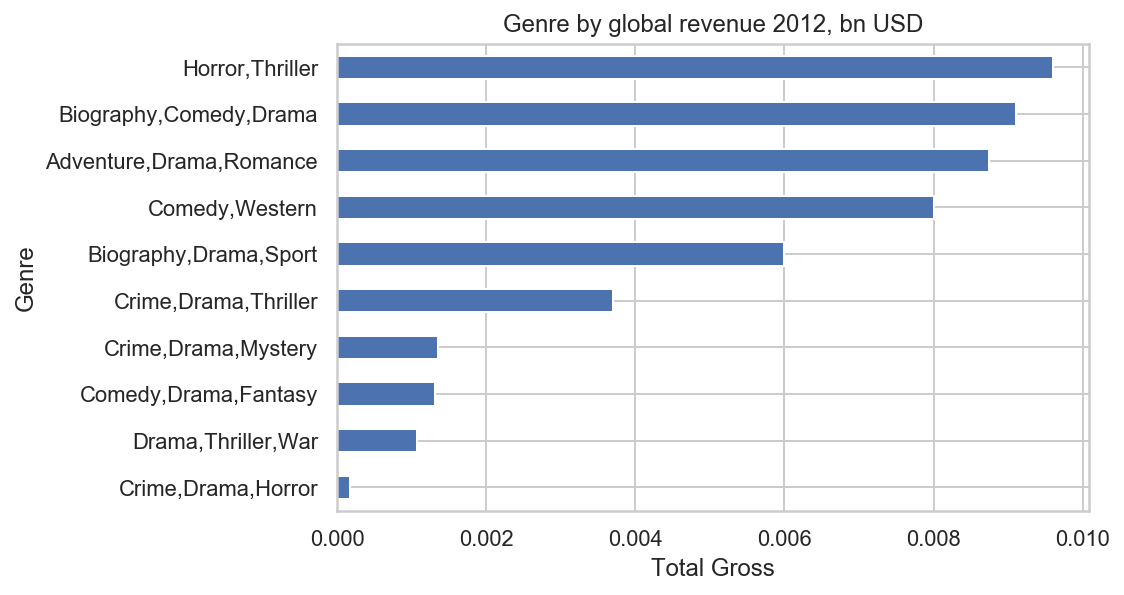

In [7]:
# Plot top 10 genres by revenue 
popular_movies = highly_rated_movies.total_gross.sort_values(ascending=True)
popular_movies = popular_movies.head(10)
popular_movies.plot(x='genres', y = ['total_gross'], kind = 'barh', color='b')
plt.title("Genre by global revenue 2012, bn USD")
plt.ylabel("Genre")
plt.xlabel("Total Gross")
plt.show()

#### Question 2. What are the most successful genres by ROI?

The most successful genres are:
- "Horor"
- "Horror, Mystery, Thriller"

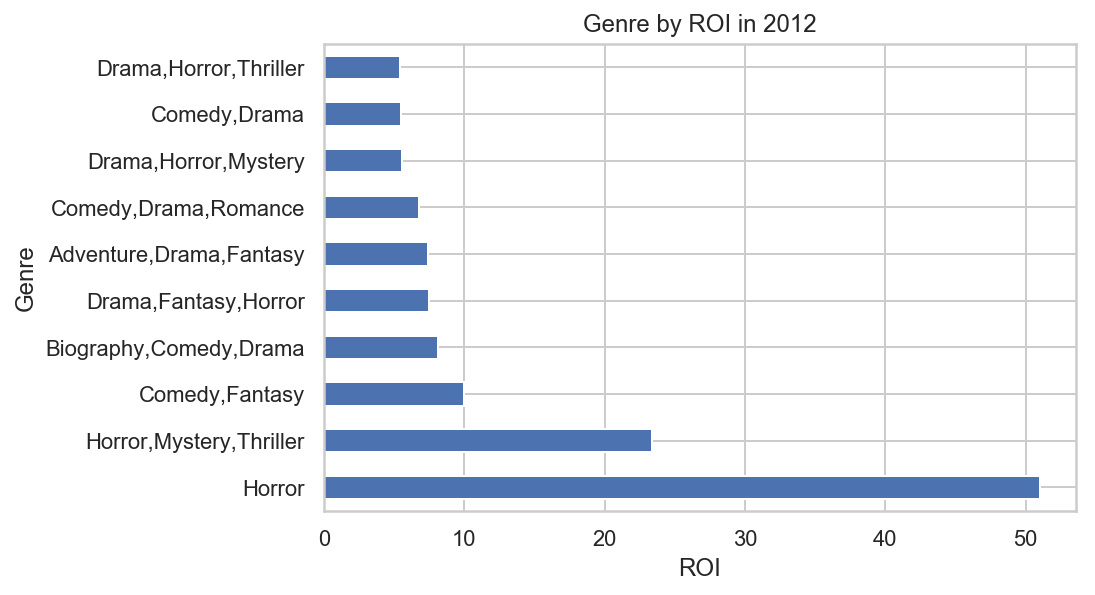

In [8]:
# Plot top 10 genres by ROI 
popular_movies = highly_rated_movies.ROI.sort_values(ascending=False)
popular_movies = popular_movies.head(10)
popular_movies.plot(x='genres', y = ['ROI'], kind = 'barh', color='b')
plt.title("Genre by ROI in 2012")
plt.ylabel("Genre")
plt.xlabel("ROI")
plt.show()

#### Question 3. What are the most popular movie genres?

The most popular genres are:
- "Drama, Horror, Thriller"
- "Horror"

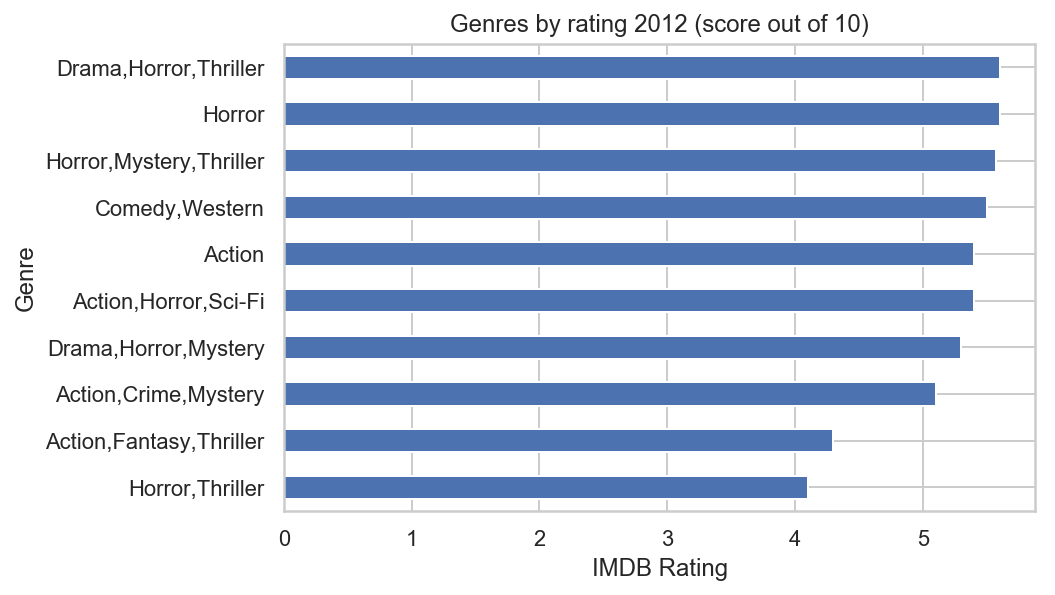

In [9]:
# Plot top 10 genres by ratings 
highly_rated = highly_rated_movies.averagerating.sort_values(ascending=True)
highly_rated = highly_rated.head(10)
highly_rated.plot(x='genres', y = ['averagerating'], kind = 'barh', color='b')
plt.title("Genres by rating 2012 (score out of 10)")
plt.ylabel("Genre")
plt.xlabel("IMDB Rating")
plt.show()

#### Question 4. Do higher IMDB ratings lead to higher movie revenues?

It cannot be observed that higher IMDB ratings lead to higher movie revenues

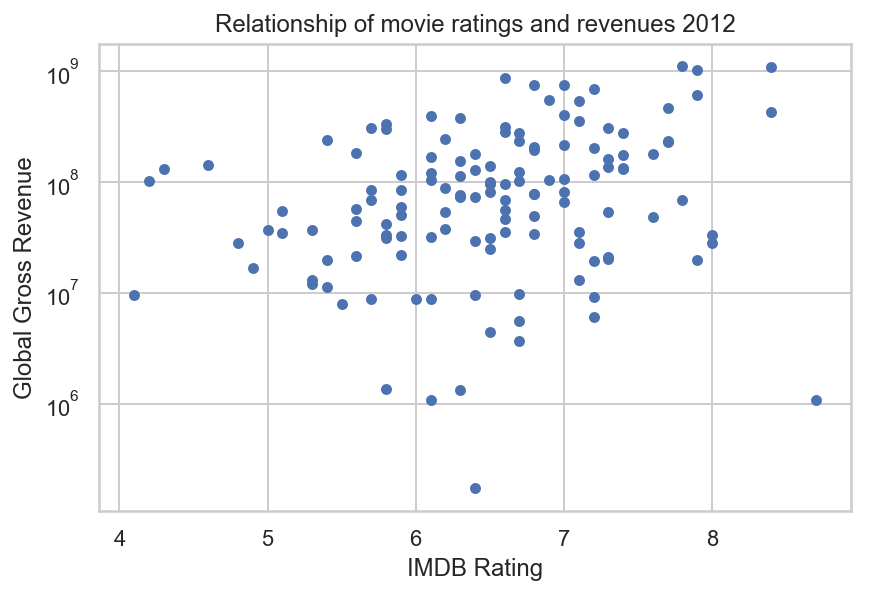

Ttest_indResult(statistic=8.328845045819119, pvalue=4.4779038224305236e-15)

In [10]:
# Plot relationship of movie ratings and gross revenues 2012
popularity_revenue_relationship = df[df.year == 2012]
popularity_revenue_relationship.plot(x='averagerating', y = ['total_gross'], kind = 'scatter',logy=True, color='b')
plt.title("Relationship of movie ratings and revenues 2012")
plt.xlabel("IMDB Rating")
plt.ylabel("Global Gross Revenue")
plt.show()

# Statistical relevance test of relationships
from scipy.stats import ttest_ind
ttest_ind(popularity_revenue_relationship['total_gross'], popularity_revenue_relationship['averagerating'])

#### Question 5. Have high grossing movies automatically a higher ROI?

It can be observed that higher grossing movies have a relevant higher ROI

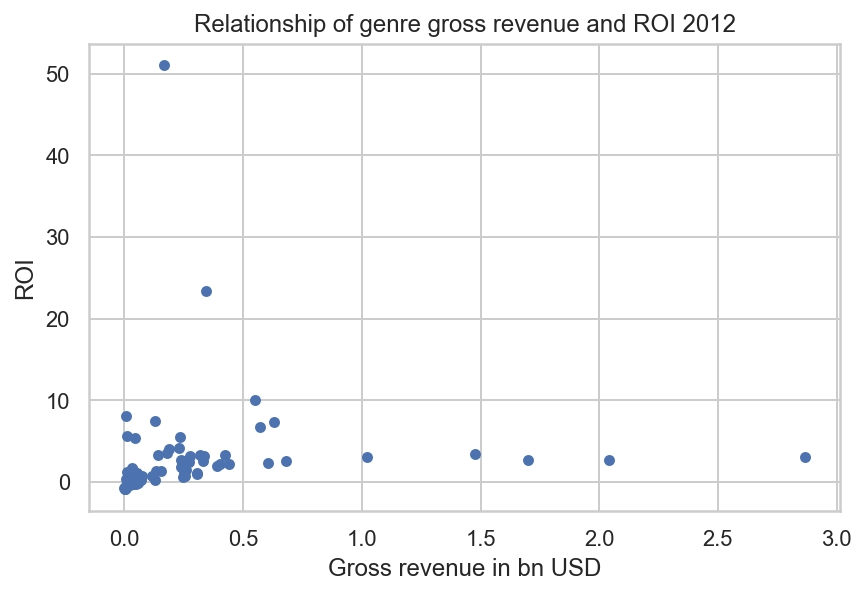

Ttest_indResult(statistic=3.3299151981820034, pvalue=0.0011144549238387696)
Cohen's D -0.5628583995257342


In [11]:
# Plot relationship of gross revenues and ROI 2012
highly_rated_movies.plot(x='total_gross', y = ['ROI'], kind = 'scatter', color='b')
plt.title("Relationship of genre gross revenue and ROI 2012")
plt.xlabel("Gross revenue in bn USD")
plt.ylabel("ROI")
plt.show()

# Statistical relevance test of relationships
print(ttest_ind(highly_rated_movies['ROI'], highly_rated_movies['total_gross']))

# Effect size
cohens_d = (mean(highly_rated_movies.total_gross) - mean(highly_rated_movies.ROI)) / (sqrt((stdev(highly_rated_movies.total_gross) ** 2 + stdev(highly_rated_movies.ROI) ** 2) / 2))
print("Cohen's D", cohens_d)

#### Question 6. Who are the best directors to partner with in winning genres?

We recomend Microsoft patner with Directors with high ROI. We were able to identify only one director with a high ROI and also a high IMDB ratings.

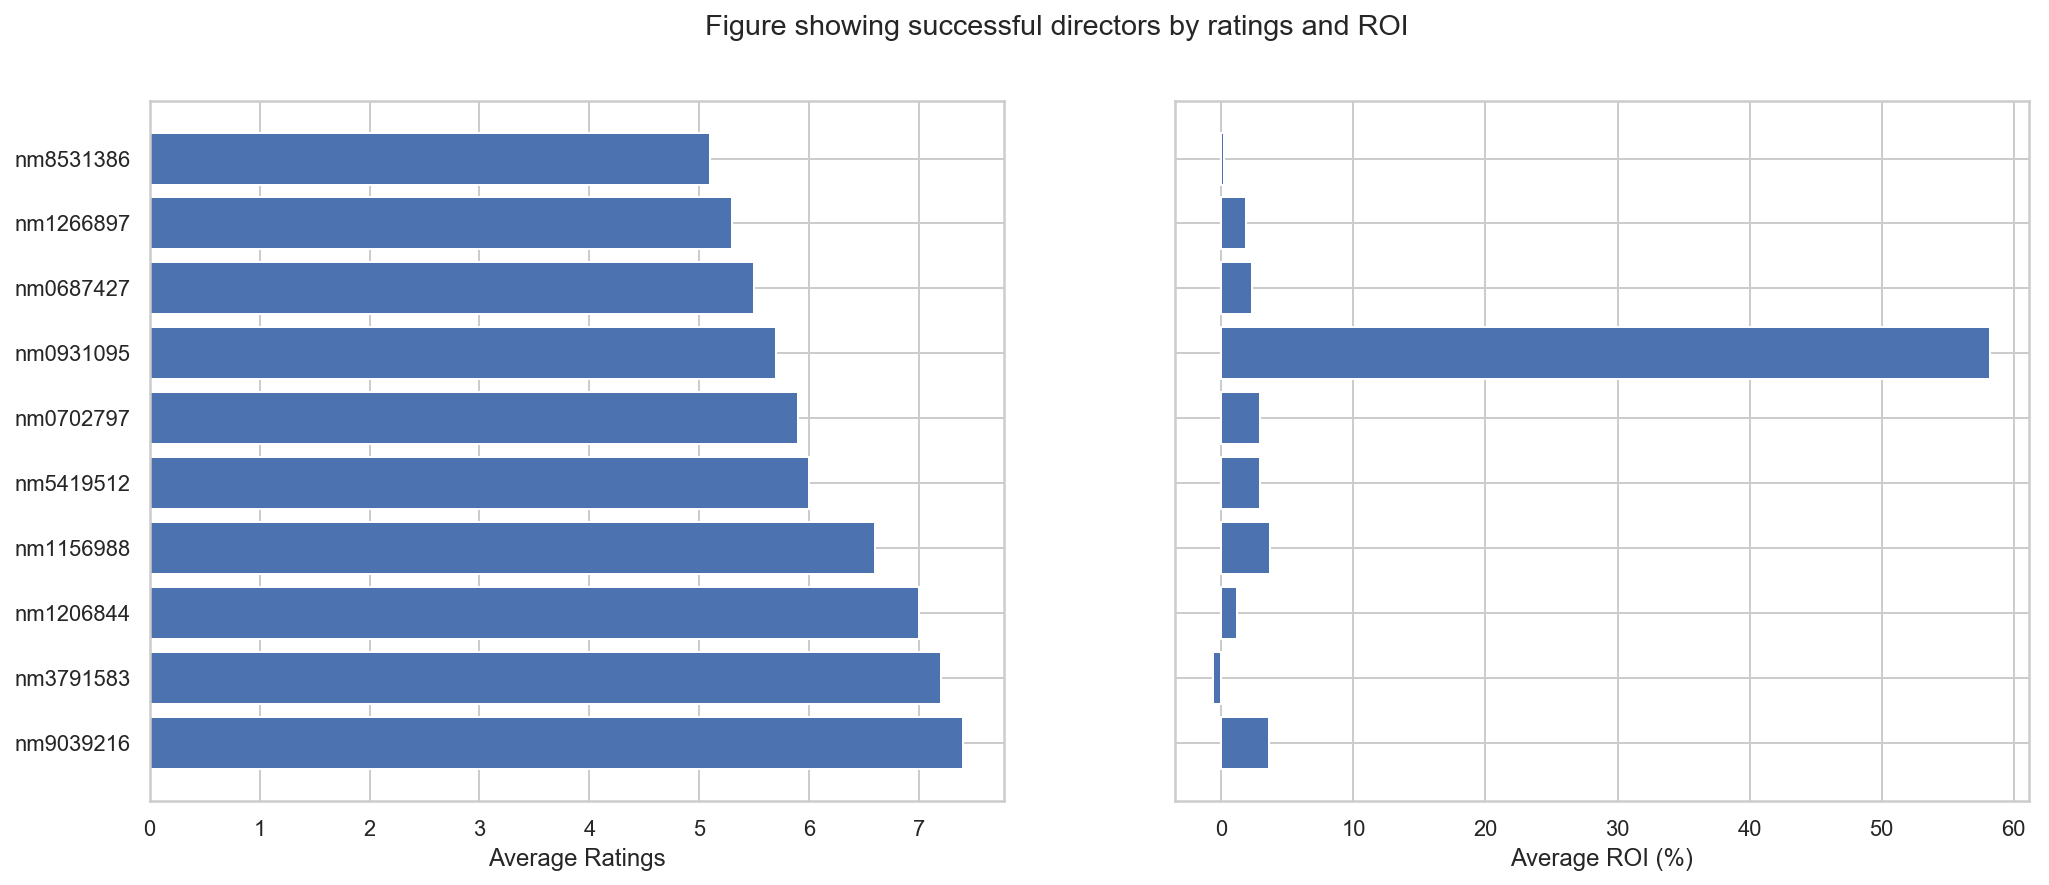

In [12]:
# analyzing data to identify top 10 directors by average ratings
mov_dir = df
mov_dir.dropna(subset=['director1'], inplace=True)  #droping empty cells in director column
mov_dir['director1'].replace('', np.nan, inplace=True)
mov_dir = df[df['genres'] == 'Horror'] # filtering for a specific genre
# mov_dir = mov_dir.loc[mov_dir['numvotes'] >= 500]
# mov_dir = mov_dir[mov_dir['numvotes'] >= 1000]
mov_dir = mov_dir.groupby(['director1', 'genres']).mean().reset_index()
mov_dir = mov_dir.sort_values(["averagerating"], ascending = False) #sorting values from highest to lowest
mov_dir = mov_dir.head(10)
# print(mov_dir)
# ploting figure to show top 10 directors by average ratings and their ROIs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Figure showing successful directors by ratings and ROI')
ax1.barh(mov_dir['director1'], mov_dir['averagerating'])
ax2.barh(mov_dir['director1'], mov_dir['ROI'])

ax2.set_yticklabels([])
ax2.set_xlabel('Average ROI (%)')
ax1.set_xlabel('Average Ratings');

#### Question 7. What are the common runtimes by genre?

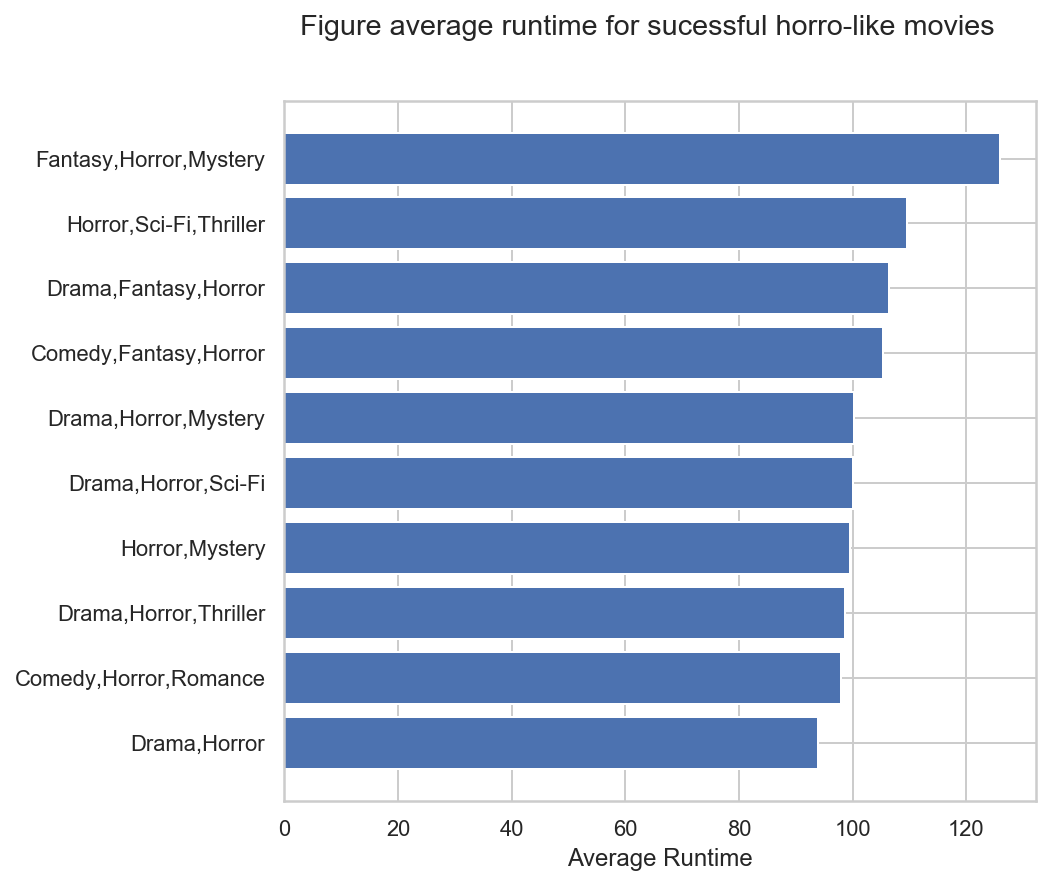

In [13]:
# analyzing data to identify runtime for top 10 Horror related movies 
gen_time = df[df['genres'].str.contains("Horror")]
gen_time = gen_time.groupby(['genres']).mean().reset_index()
gen_time = gen_time.sort_values(["averagerating"], ascending = False) #sorting values from highest to lowest
gen_time = gen_time.head(10)
gen_time = gen_time.sort_values(["runtime_minutes"], ascending = True)
# ploting figure to show runtime for the top 10 Horror related genre by average run-time
fig, (ax1) = plt.subplots(figsize=(6, 6))
fig.suptitle('Figure average runtime for sucessful horro-like movies')
plt.xlabel('Average Runtime')
ax1.barh(gen_time['genres'], gen_time['runtime_minutes']);

#### Question 8. Which studio should Microsoft partner with?

DR and LD are the highest grossing movie studios

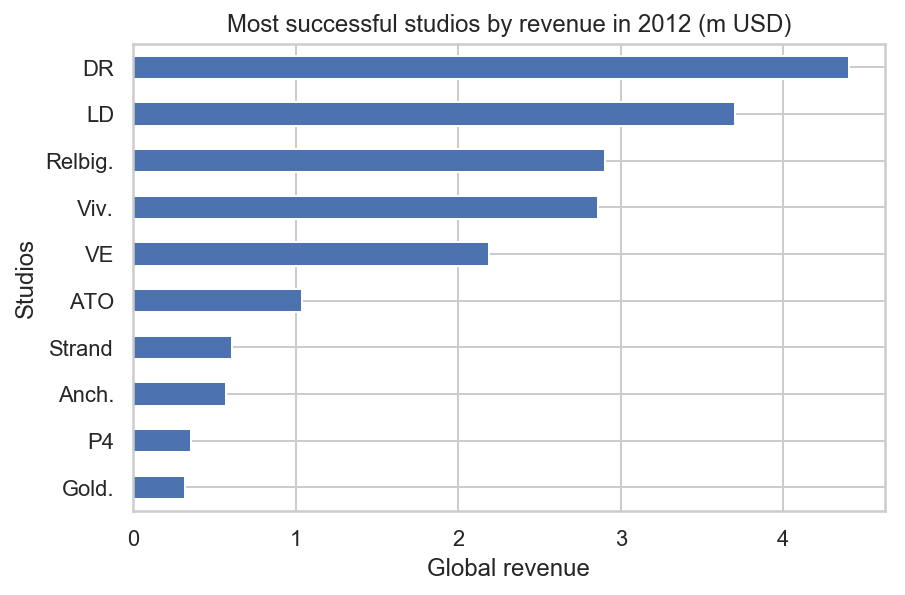

In [14]:
# Total_gross revenue is being converted to m USD
best_studios = df
best_studios["total_gross"] = best_studios.apply(lambda row: row.total_gross / 1000000 ,axis=1)

# Anaylysing 10 highest grossing studios to partner with
best_studios = df.groupby('studio').sum().sort_values("total_gross").total_gross.head(10)

# Plot highest grossing studios in m USD
best_studios.plot(x='studios', y = ['total_gross'], kind = 'barh', color='b')
plt.title("Most successful studios by revenue in 2012 (m USD)")
plt.xlabel("Global revenue")
plt.ylabel("Studios")
plt.show()

### Backup:

#### Ratings by genre and ROI are also not observed to have a signficant relationship

In [ ]:
# Plot relationship of genre ratings and gross revenues 2012
highly_rated_movies.plot(x='averagerating', y = ['ROI'], kind = 'scatter', color='b')
plt.title("Relationship of genre ratings and ROI 2012")
plt.xlabel("IMDB Rating")
plt.ylabel("ROI")
plt.show()

# Statistical relevance test of relationships
from scipy.stats import ttest_ind
ttest_ind(highly_rated_movies['ROI'], highly_rated_movies['averagerating'])